In [5]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import json

In [6]:
markers = ['o', '*', 'v', '^', '<', 's']
sns.set_palette(palette=['#495867','#577399','#BDD5EA','#3A7E5E','#B5CA8D'])
plt.rcParams.update({"text.usetex": True, "font.family" : "serif", "font.serif" : ["Computer Modern Serif"]})

In [7]:
# Function to calculate the total demand
def calculate_total_demand(data):
    total_demand = 0
    scenarios = data['scenarios']
    for scenario in scenarios:
        for area_data in scenario['data']:
            total_demand += sum(area_data['demand'])
    return total_demand/data['num_scenarios']

In [8]:
# Load in files
directory = '../../raw_results'
file_names = os.listdir(directory)

results_df = pd.DataFrame()

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)

    # Calculate number of total packages
    pattern = r'^(.+?)_OC'
    base_name = re.search(pattern, file_names[i]).group(1)
    weekday_path = f'../../instances/{base_name}_dt=doublepeak.json'
    weekend_path = f'../../instances/{base_name}_dt=uniform.json'

    with open(weekday_path, 'r') as file:
        weekday = json.load(file)

    with open(weekend_path, 'r') as file:
        weekend = json.load(file)

    weekend_demand = calculate_total_demand(weekend)
    weekday_demand = calculate_total_demand(weekday)
    total_demand = weekend_demand*2 + weekday_demand*5

    # Obtain baseline results
    keys_to_keep = ['city', 'demand_baseline', 'outsourcing_cost_multiplier', 'model', 'max_n_shifts', 'workforce_size', 'wage_costs', 'objective_value', 'objective_value_post_wage']
    filtered_baseline = {key: sol['baseline'][key] for key in keys_to_keep}
    results_temp = pd.DataFrame(filtered_baseline)


    # Deal with region key inconsistency
    if 'region' in sol.keys():
        regions = sol['region']
    else:
        regions =  sol['regions']


    # Add the roster results
    obj_val = sol['obj_val']
    wage_costs = sum( (employee, shift_start, day) in sol['r']
                    for region in regions 
                    for employee in sol['employees'][region]
                    for day in sol['days']
                    for shift_start in sol['shifts'][(region, day)])*4
    outsourcing_costs	= obj_val - wage_costs

    results_temp['objective_value_roster'] = sol['obj_val']
    results_temp['wage_costs_roster'] = wage_costs
    results_temp['objective_value_post_wage_roster'] = outsourcing_costs
    results_temp['roster_baseline_diff'] = results_temp['objective_value_roster'] - results_temp['objective_value'] 
    results_temp['total_packages'] = total_demand
    results_temp['baseline_cost_per_package'] = results_temp['objective_value']/total_demand
    results_temp['roster_cost_per_package'] = results_temp['objective_value_roster']/total_demand
    results_temp['difference_cost_per_package'] = results_temp['roster_cost_per_package'] - results_temp['baseline_cost_per_package']
    results_df = pd.concat([results_df, results_temp], axis=0, ignore_index=True)

# Fix model names
results_df['model'] = np.where(
    results_df['max_n_shifts'].notna(),  # Condition to check non-null values
    results_df['model'] + '-' + results_df['max_n_shifts'].astype(str),  # True condition
    results_df['model']  # False condition, keep the original 'model'
)

In [9]:
results_df

,city,demand_baseline,outsourcing_cost_multiplier,model,max_n_shifts,workforce_size,wage_costs,objective_value,objective_value_post_wage,objective_value_roster,wage_costs_roster,objective_value_post_wage_roster,roster_baseline_diff,total_packages,baseline_cost_per_package,roster_cost_per_package,difference_cost_per_package
0,paris,1.0,1.5,partflex-3.0,3.0,198,4169.0,4842.281914,673.281914,5896.088098,4364,1532.088098,1053.806184,15578.866667,0.310824,0.378467,0.067643
1,lyon,1.0,2.0,partflex-3.0,3.0,108,1990.0,2270.265926,280.265926,2473.691853,2208,265.691853,203.425927,6092.800000,0.372615,0.406002,0.033388
2,lyon,4.0,1.2,partflex-3.0,3.0,317,6287.0,6809.246178,522.246178,7758.414550,7028,730.414550,949.168372,24813.000000,0.274423,0.312675,0.038253
3,frankfurt,2.0,1.5,fixed,NaN,199,2629.0,3098.070833,469.070833,3967.520833,3552,415.520833,869.450000,7697.933333,0.402455,0.515401,0.112946
4,paris,0.5,1.8,partflex-3.0,3.0,113,2424.0,2833.881857,409.881857,3381.804856,2520,861.804856,547.922999,7705.200000,0.367788,0.438899,0.071111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,paris,0.5,2.5,flex,NaN,118,2506.0,2938.666468,432.666468,3619.797023,2612,1007.797023,681.130555,7705.200000,0.381387,0.469786,0.088399
246,paris,2.0,1.2,partflex-4.0,4.0,351,7545.0,8992.193477,1447.193477,10953.101825,7964,2989.101825,1960.908348,31559.800000,0.284926,0.347059,0.062133
247,frankfurt,4.0,1.2,fixed,NaN,342,4467.0,5104.804698,637.804698,6779.654127,6116,663.654127,1674.849429,15528.666667,0.328734,0.436590,0.107855
248,lyon,2.0,1.8,partflex-4.0,4.0,181,3545.0,3861.843812,316.843812,4333.897516,4040,293.897516,472.053704,12232.133333,0.315713,0.354304,0.038591


# Cost Graphs

## By OC multiplier

In [10]:
# Calculate averages
cost_df_by_oc = results_df[['model', 'outsourcing_cost_multiplier', 'baseline_cost_per_package', 'difference_cost_per_package']]
cost_df_by_oc = cost_df_by_oc.copy()
cost_df_by_oc = cost_df_by_oc.groupby(['outsourcing_cost_multiplier', 'model']).mean()
cost_df_by_oc = cost_df_by_oc.reset_index()

In [11]:
def plot_cost_oc(data):
    # Set the line width for hatching in the bar plots
    plt.rcParams['hatch.linewidth'] = 1

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(10,6))

    n_models = 5
    n_oc = 5

    oc_values = [1.2, 1.5, 1.8, 2.0, 2.5]
    models = ['flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    # Calculate the x positions for the ticks to be centered between grouped bars
    ticks = [(x1 + x2) / 2 for x1, x2 in zip(range(1, n_oc * (n_models + 1), n_models + 1), range(n_models, (n_oc + 1) * (n_models + 1), n_models + 1))]


    for rm_idx, oc in enumerate(oc_values):
        for model_idx, model in enumerate(models):
            bar_x = rm_idx * (n_models + 1) + model_idx + 1
            baseline = data[(data['outsourcing_cost_multiplier'] == oc) & (data['model'] == model)]['baseline_cost_per_package'].values[0]
            roster = data[(data['outsourcing_cost_multiplier'] == oc) & (data['model'] == model)]['difference_cost_per_package'].values[0]

            # Plot outsourcing costs as the base bar
            ax.bar(x=[bar_x], height=[baseline], color=f"C{model_idx}", linewidth=1, edgecolor='white')
            # Plot hiring costs stacked on outsourcing costs
            ax.bar(x=[bar_x], height=[roster], bottom=[baseline], color=f"C{model_idx}", linewidth=1, edgecolor='white', hatch='\\')

    # Set the x-ticks to the center of the grouped bars and label them with the RM names
    ax.set_xticks(ticks)
    ax.set_xticklabels(oc_values)
    ax.set_xlabel('\\texttt{OC}', fontsize=16, labelpad=10)  # Using LaTeX for styling text
    ax.set_ylabel('Avg cost per parcel', fontsize=16)
    ax.yaxis.grid(which='major')  # Add horizontal grid lines for the y-axis
    ax.set_axisbelow(True)  # Set the grid lines behind the bars

    # Adjust font sizes of tick labels
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Remove x-axis tick marks
    ax.tick_params(which='major', axis='x', length=0)

    # Create a custom legend
    ax.legend(handles=[
            Patch(facecolor='C0', edgecolor='C0'),
            Patch(facecolor='C1', edgecolor='C1'),
            Patch(facecolor='C2', edgecolor='C2'),
            Patch(facecolor='C3', edgecolor='C3'),
            Patch(facecolor='C4', edgecolor='C4'),
            Patch(facecolor='white', edgecolor='black'),
            Patch(facecolor='white', edgecolor='black', hatch='\\\\')
        ],
        labels=[
            '\\textsc{Flex}', '\\textsc{PartFlex} ($\\mu = 4$)', '\\textsc{PartFlex} ($\\mu = 3$)', '\\textsc{PartFlex} ($\\mu = 2$)',
            '\\textsc{Fixed}', 'Baseline cost', 'Rostering cost'
        ],
        loc='lower center', bbox_to_anchor=(0.5, -0.4),
        ncol=4, fontsize=14, frameon=False,
        handletextpad=0.25
    )

    # Adjust layout to make room for elements and save the figure
    fig.tight_layout()
    fig.savefig('rm_vs_cost.pdf', dpi=96, bbox_inches='tight')
    return fig, ax

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='\\texttt{OC}', ylabel='Avg cost per parcel'>)

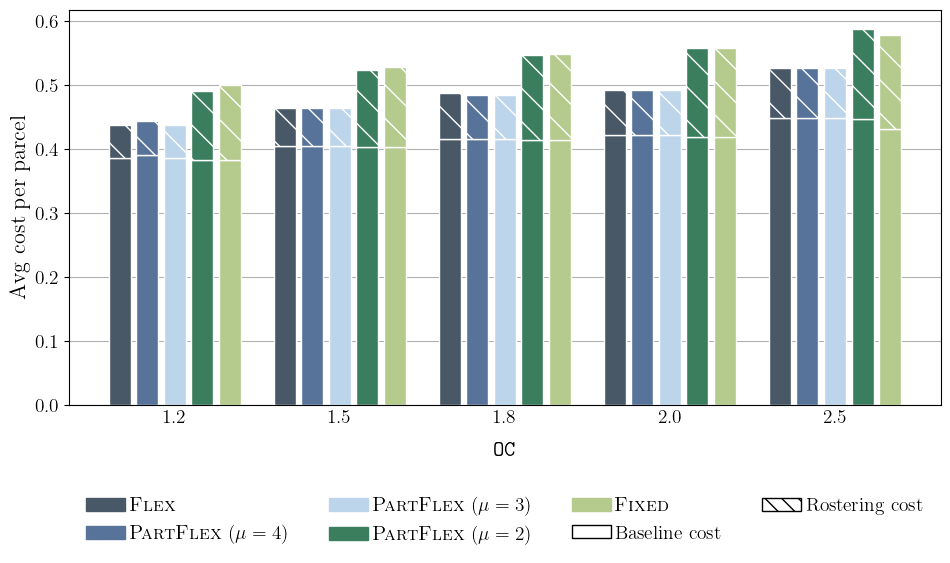

In [12]:
plot_cost_oc(cost_df_by_oc)

## By demand baseline

In [13]:
# Calculate averages
cost_df_by_db = results_df[['model', 'demand_baseline', 'baseline_cost_per_package', 'difference_cost_per_package']]
cost_df_by_db = cost_df_by_db.copy()
cost_df_by_db = cost_df_by_db.groupby(['demand_baseline', 'model']).mean()
cost_df_by_db = cost_df_by_db.reset_index()
cost_df_by_db

,demand_baseline,model,baseline_cost_per_package,difference_cost_per_package
0,0.5,fixed,0.537057,0.152420
1,0.5,flex,0.539036,0.086692
2,0.5,partflex-2.0,0.537057,0.141001
3,0.5,partflex-3.0,0.539036,0.085350
4,0.5,partflex-4.0,0.539036,0.085350
5,1.0,fixed,0.403782,0.121252
6,1.0,flex,0.405658,0.063339
7,1.0,partflex-2.0,0.403782,0.121252
8,1.0,partflex-3.0,0.405658,0.063339
9,1.0,partflex-4.0,0.405658,0.063339


In [21]:
data = cost_df_by_db
db = 0.5
model = 'flex'
baseline = data[(data['demand_baseline'] == db) & (data['model'] == model)]['baseline_cost_per_package'].values[0]
baseline

0.5390363300775964

In [28]:
def plot_cost_db(data):
    # Set the line width for hatching in the bar plots
    plt.rcParams['hatch.linewidth'] = 1

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(10,6))

    n_models = 5
    n_db = 4

    db_values = [0.5, 1.0, 2.0, 4.0]
    models = ['flex', 'partflex-4.0', 'partflex-3.0', 'partflex-2.0', 'fixed']

    # Calculate the x positions for the ticks to be centered between grouped bars
    ticks = [(x1 + x2) / 2 for x1, x2 in zip(range(1, n_db * (n_models + 1), n_models + 1), range(n_models, (n_db + 1) * (n_models + 1), n_models + 1))]


    for rm_idx, db in enumerate(db_values):
        for model_idx, model in enumerate(models):
            bar_x = rm_idx * (n_models + 1) + model_idx + 1
            baseline = data[(data['demand_baseline'] == db) & (data['model'] == model)]['baseline_cost_per_package'].values[0]
            roster = data[(data['demand_baseline'] == db) & (data['model'] == model)]['difference_cost_per_package'].values[0]

            # Plot outsourcing costs as the base bar
            ax.bar(x=[bar_x], height=[baseline], color=f"C{model_idx}", linewidth=1, edgecolor='white')
            # Plot hiring costs stacked on outsourcing costs
            ax.bar(x=[bar_x], height=[roster], bottom=[baseline], color=f"C{model_idx}", linewidth=1, edgecolor='white', hatch='\\')

    # Set the x-ticks to the center of the grouped bars and label them with the RM names
    ax.set_xticks(ticks)
    ax.set_xticklabels(db_values)
    ax.set_xlabel('\\texttt{DB}', fontsize=16, labelpad=10)  # Using LaTeX for styling text
    ax.set_ylabel('Avg cost per parcel', fontsize=16)
    ax.yaxis.grid(which='major')  # Add horizontal grid lines for the y-axis
    ax.set_axisbelow(True)  # Set the grid lines behind the bars

    # Adjust font sizes of tick labels
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Remove x-axis tick marks
    ax.tick_params(which='major', axis='x', length=0)

    # Create a custom legend
    ax.legend(handles=[
            Patch(facecolor='C0', edgecolor='C0'),
            Patch(facecolor='C1', edgecolor='C1'),
            Patch(facecolor='C2', edgecolor='C2'),
            Patch(facecolor='C3', edgecolor='C3'),
            Patch(facecolor='C4', edgecolor='C4'),
            Patch(facecolor='white', edgecolor='black'),
            Patch(facecolor='white', edgecolor='black', hatch='\\\\')
        ],
        labels=[
            '\\textsc{Flex}', '\\textsc{PartFlex} ($\\mu = 4$)', '\\textsc{PartFlex} ($\\mu = 3$)', '\\textsc{PartFlex} ($\\mu = 2$)',
            '\\textsc{Fixed}', 'Baseline cost', 'Rostering cost'
        ],
        loc='lower center', bbox_to_anchor=(0.5, -0.4),
        ncol=4, fontsize=14, frameon=False,
        handletextpad=0.25
    )

    # Adjust layout to make room for elements and save the figure
    fig.tight_layout()
    fig.savefig('rm_vs_cost.pdf', dpi=96, bbox_inches='tight')
    return fig, ax

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='\\texttt{DB}', ylabel='Avg cost per parcel'>)

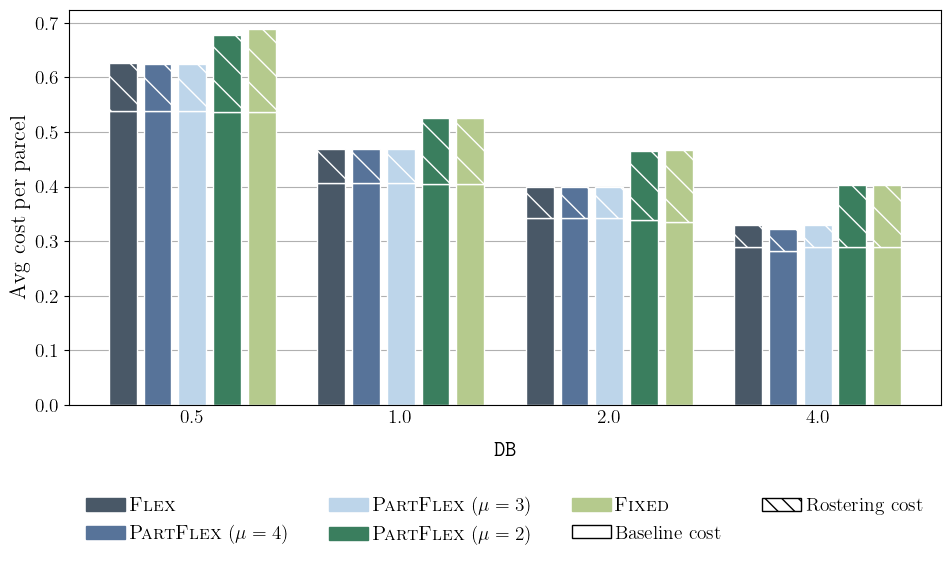

In [29]:
plot_cost_db(cost_df_by_db)